In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.externals import joblib
#import warnings
#warnings.filterwarnings("ignore")
df_train = pd.read_csv('../input/train.csv')
df_y_train = pd.read_csv('../input/y_train.csv')
df_val = pd.read_csv('../input/val.csv')
df_y_val = pd.read_csv('../input/y_val.csv')
train = df_train['review'].to_numpy()
y_train = df_y_train['rate'].to_numpy()
val = df_val['review'].to_numpy()
y_val = df_y_val['rate'].to_numpy()

# the data set is merge here for crossvalidation in the Bayesian Inference analysis. 
'''
train_total = pd.DataFrame({'review':train.tolist()+val.tolist()})
train_y_total = pd.DataFrame({'rate':y_train.tolist()+y_val.tolist()})
train_total.to_csv('../input/train_total.csv')
train_y_total.to_csv('../input/train_y_total.csv')
'''

vectorizer = TfidfVectorizer(stop_words='english',use_idf=True)
model_tr = vectorizer.fit_transform(train)
model_val = vectorizer.transform(val)

/home/zixi/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [14]:
from sklearn.decomposition import PCA
#from sklearn.preprocessing import normalize
#model_tr_normalize = normalize(model_tr, norm='l2', axis=0, copy=True, return_norm=False)
pca = PCA(n_components = 0.95)
pca.fit(model_tr.toarray())
reduced = pca.transform(model_tr.toarray())
print(reduced.shape)

(22159, 3192)


In [2]:
from sklearn.decomposition import PCA
model_tr1 = model_tr
model_val1 = model_val
#pca = joblib.load('../input/model/pca.pkl')
model_val = pca.transform(model_val.toarray())
model_tr = pca.transform(model_tr.toarray())


In [5]:
# Logistic regression, L1 regularization, weighted loss, hyperparameter selection use validation set, macro-weighted score to select model
# reason: we assume that some of the variable which is corresponding to the word contribute little to emotion(rating) 
# and we give more weight to the minor class to remedy for the class imblance. 
import warnings
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore")
n_alphas = 76
#alphas = np.exp(np.linspace(-5,10,n_alphas))
C = np.exp(np.linspace(-5,10,n_alphas))
train_score = []
val_score = []
for i in C:
    m = LogisticRegression(penalty='l1',C=i,class_weight='balanced').fit(model_tr, y_train)
    s = f1_score(y_val, m.predict(model_val), average='macro')
    train_score.append(f1_score(y_train, m.predict(model_tr), average='macro'))
    val_score.append(f1_score(y_val, m.predict(model_val), average='macro'))
    print ('Val macro score is', s)
#plt.plot(np.log10(C),train_score,label='train')
#plt.plot(np.log10(C),val_score,label='val')
#plt.title('macro score of training set and validation set')
#plt.legend()
#plt.xlabel('log10(C)')
#plt.ylabel('macro score')
#plt.show()
#-------------------

Val macro score is 0.16284246575342465
Val macro score is 0.16284246575342465
Val macro score is 0.16284246575342465
Val macro score is 0.164455211614093
Val macro score is 0.1657112828076619
Val macro score is 0.17570742777341367
Val macro score is 0.19491367167594104
Val macro score is 0.20174409813477032
Val macro score is 0.22126528128546624
Val macro score is 0.22586154987080748
Val macro score is 0.24070227088220175
Val macro score is 0.2554064920128435
Val macro score is 0.26751713162752155
Val macro score is 0.27210590605754337
Val macro score is 0.28738143931693544
Val macro score is 0.29713566882520426
Val macro score is 0.305405194853131
Val macro score is 0.3127471027167378
Val macro score is 0.32404309743892934
Val macro score is 0.32651390324407936
Val macro score is 0.3285874760354234
Val macro score is 0.33521921239368113
Val macro score is 0.34103968228517645
Val macro score is 0.3476187047108586
Val macro score is 0.35525953334736504
Val macro score is 0.3529957679279

KeyboardInterrupt: 

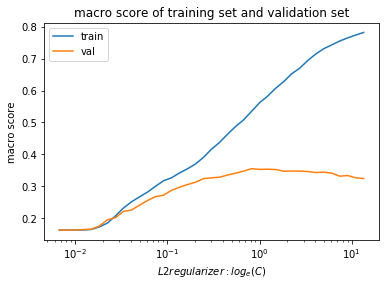

Best Val macro score is 0.3626043565870517
confusion matrix is: 
 [[  26    8   16    3   12]
 [  16   14   18    8    8]
 [  22   22   73   54   69]
 [  23   29  159  369  787]
 [  37   42  120  400 3205]]
recall of each class:
 [0.4, 0.2188, 0.3042, 0.2699, 0.8425]


['../input/model/logistic_L2.pkl']

In [6]:
from sklearn.metrics import confusion_matrix
ax = plt.gca()
# randomly choose 50 coefficients in the 9676 variables 
# to plot figure of coefs vs regularizer. 
ax.plot(C[:len(train_score)], train_score,label='train')
ax.plot(C[:len(train_score)], val_score,label='val')
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('$L2 regularizer: log_e(C)$')
plt.ylabel('macro score')
plt.legend()
plt.title('macro score of training set and validation set')
plt.axis('tight')
plt.show()
C_opt = C[np.argmax(val_score)]
m_opt = LogisticRegression(C=C_opt,class_weight='balanced').fit(model_tr, y_train)
s = f1_score(y_val, m_opt.predict(model_val), average='macro')
mat = confusion_matrix(y_val, m_opt.predict(model_val))
print ('Best Val macro score is', s)
print('confusion matrix is: \n',mat)
print('recall of each class:\n',[round(mat[0,0]/mat[0,:].sum(),4), round(mat[1,1]/mat[1,:].sum(),4),
                                  round(mat[2,2]/mat[2,:].sum(),4),round(mat[3,3]/mat[3,:].sum(),4),
                                  round(mat[4,4]/mat[4,:].sum(),4)])
joblib.dump(m_opt,'../input/model/logistic_L1.pkl')